In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-04 04:52:28.440949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 04:52:28.440970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [7]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [9]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [10]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [11]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [12]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
transform_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=5,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:400.6949, Loss-ae:360.4574, Loss-topo:8.0475
Epoch:2, P:10, Loss:305.1322, Loss-ae:295.0248, Loss-topo:2.0215
Epoch:3, P:10, Loss:281.8999, Loss-ae:273.5842, Loss-topo:1.6631
Epoch:4, P:10, Loss:259.4071, Loss-ae:255.0362, Loss-topo:0.8742
Epoch:5, P:10, Loss:352.1544, Loss-ae:343.4515, Loss-topo:1.7406
Epoch:6, P:9, Loss:265.5029, Loss-ae:263.2208, Loss-topo:0.4564
Epoch:7, P:8, Loss:231.9409, Loss-ae:229.5624, Loss-topo:0.4757
Epoch:8, P:10, Loss:208.1263, Loss-ae:206.8480, Loss-topo:0.2557
Epoch:9, P:10, Loss:222.6109, Loss-ae:220.6613, Loss-topo:0.3899
Epoch:10, P:9, Loss:223.6513, Loss-ae:222.0894, Loss-topo:0.3124
Epoch:11, P:8, Loss:206.3850, Loss-ae:205.6881, Loss-topo:0.1394
Epoch:12, P:10, Loss:198.3977, Loss-ae:196.2430, Loss-topo:0.4309
Epoch:13, P:10, Loss:229.2124, Loss-ae:221.7056, Loss-topo:1.5014
Epoch:14, P:9, Loss:179.5573, Loss-ae:177.1692, Loss-topo:0.4776
Epoch:15, P:10, Loss:213.7922, Loss-ae:208.2583, Loss-topo:1.1068
Epoch:16, P:9, Loss:171.

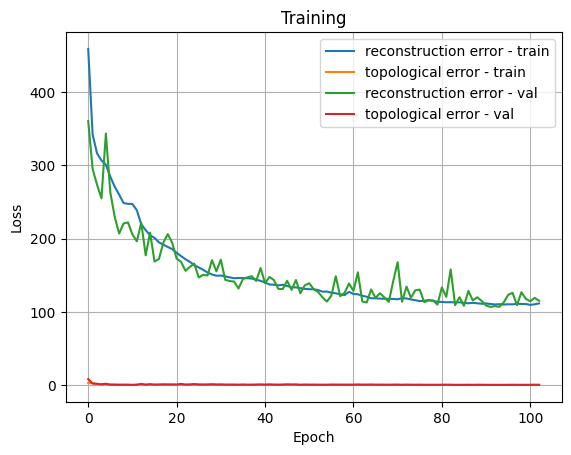

In [13]:
transform_topoae.fit(train_dataset_fft.X, train_dataset_fft.y)
# assert 1==0

In [14]:
# for epoch_obj in transform_topoae.loss_components_values:
#     print(epoch_obj['epoch'])
#     epoch_obj_loss = [val.item() for val in epoch_obj['loss']]
#     print('loss - mean', np.mean(epoch_obj_loss))
#     # epoch_obj_loss_comp = [val.item() for val in epoch_obj['loss']]
#     temp1 = [val['loss.autoencoder'].item() for val in epoch_obj['loss_components']]
#     temp2 = [val['loss.topo_error'].item() for val in epoch_obj['loss_components']]
#     temp3 = [val['reconstruction_error'].item() for val in epoch_obj['loss_components']]
#     # epoch_obj_loss_components_loss_autoencoder
#     print('loss_components - loss.autoencoders - mean', np.mean(temp1))
#     print('loss_components - loss.topo_error - mean', np.mean(temp2))
#     print('loss_components - reconstruction_error - mean', np.mean(temp3) - np.mean(temp1))

In [15]:
test_applied_topoae = transform_topoae.transform(test_dataset_fft.X)
print('ORIGINAL', test_applied_topoae.shape)
test_applied_topoae = np.reshape(test_applied_topoae, (-1,2))
print('RESHAPED', test_applied_topoae.shape)

ORIGINAL (378, 1, 2)
RESHAPED (378, 2)


In [34]:
from librep.transforms import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()


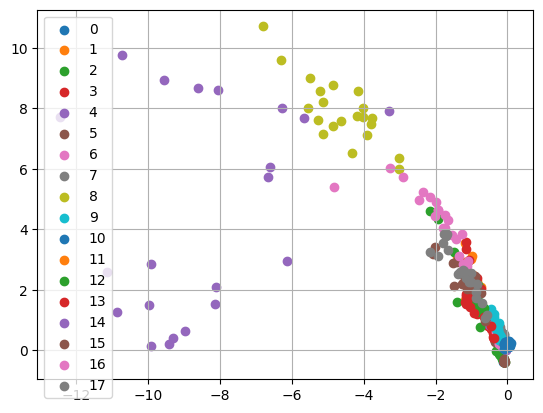

In [35]:
visualize(test_applied_topoae, test_dataset_fft.y)

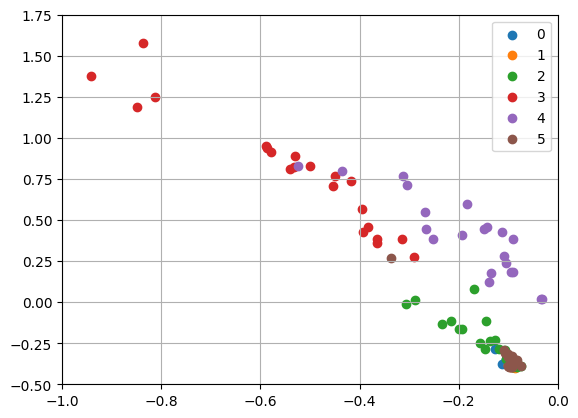

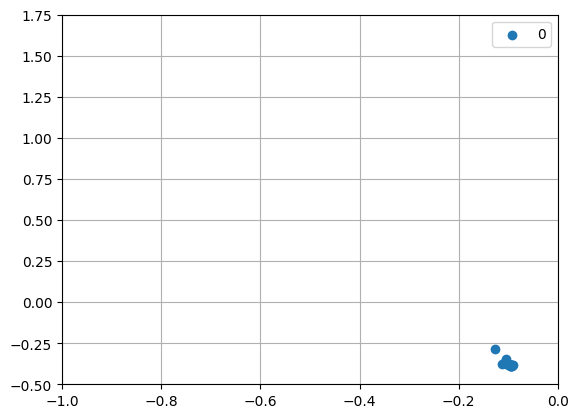

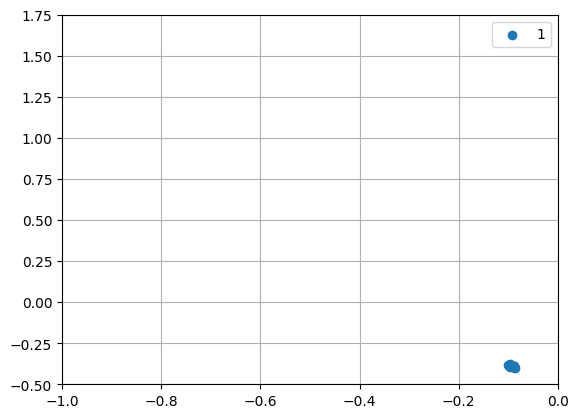

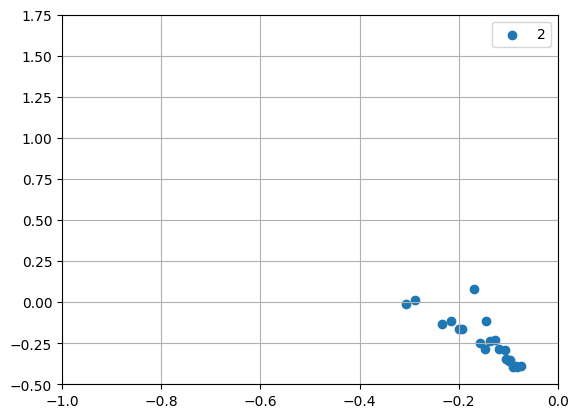

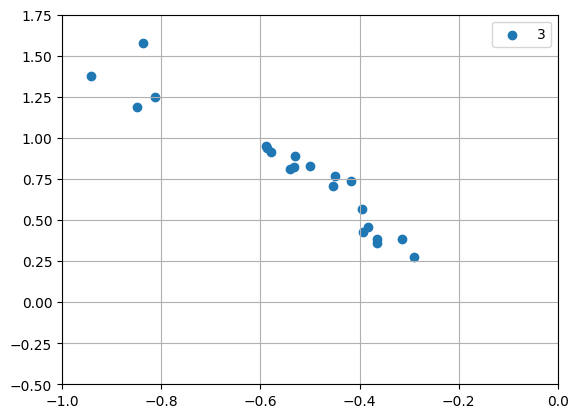

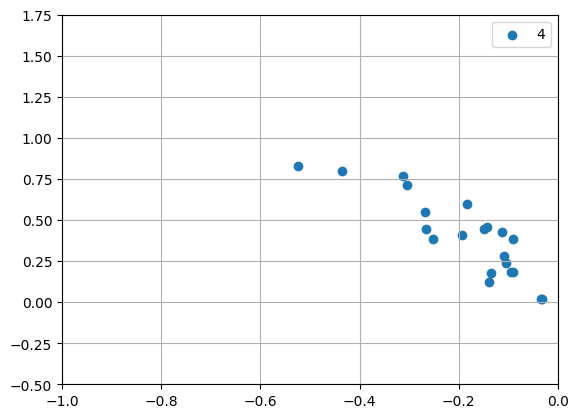

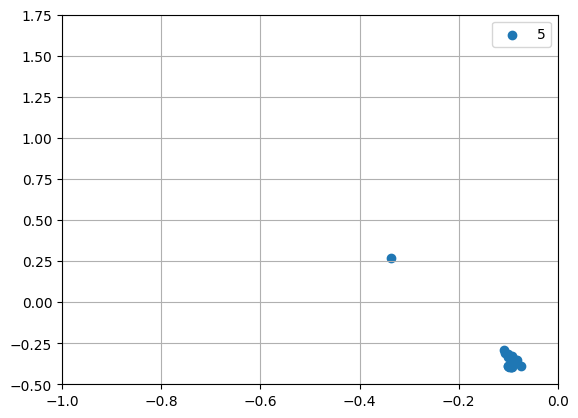

In [38]:
# filtered
filter_to_use = [0,1,2,3,4,5]
visualize(test_applied_topoae, test_dataset_fft.y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
for f in filter_to_use:
    visualize(test_applied_topoae, test_dataset_fft.y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
# visualize(test_applied_topoae, test_dataset_fft.y, filtered=[1])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

In [20]:
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
metrics_train_applied_topoae = metrics_reporter.evaluate([test_dataset_fft.X, test_applied_topoae])
print(metrics_train_applied_topoae)

{'residual variance (pearson)': 0.10240851221603664, 'residual variance (spearman)': 0.15575866684133288, 'trustworthiness': 0.8848932195419443, 'continuity': 0.9482533597360706, 'co k nearest neighbor size': 0.38561007957559684, 'local continuity meta criterion': 0.34305688808623513, 'local property': 0.4986297512443065, 'global property': 0.8807935124209015}


In [21]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [22]:
combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)


result = multi_run_experiment(combined_train_dset, test_dataset)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1664859242.295821
    result:
    -   accuracy: 0.6957671957671958
        f1 score (macro): 0.6808771270125638
        f1 score (micro): 0.6957671957671958
        f1 score (weighted): 0.7106572645218276
    run id: 1
    start: 1664859237.9599009
    time taken: 4.335920095443726
-   end: 1664859246.6557288
    result:
    -   accuracy: 0.7142857142857143
        f1 score (macro): 0.7062018017736981
        f1 score (micro): 0.7142857142857143
        f1 score (weighted): 0.7223696267977304
    run id: 2
    start: 1664859242.2958226
    time taken: 4.359906196594238
-   end: 1664859251.0064921
    result:
    -   accuracy: 0.7222222222222222
        f1 score (macro): 0.7124061212710553
        f1 score (micro): 0.7222222222222222
        f1 score (weighted): 0.7320383231733892
    run id: 3
    start: 1664859246.6557307
    time taken: 4.350761413574219



In [23]:
combined_train_dset_fft = transformer(combined_train_dset)

result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1664859253.7755227
    result:
    -   accuracy: 0.8386243386243386
        f1 score (macro): 0.835359323950549
        f1 score (micro): 0.8386243386243385
        f1 score (weighted): 0.8418893532981283
    run id: 1
    start: 1664859251.1689904
    time taken: 2.606532335281372
-   end: 1664859256.3872757
    result:
    -   accuracy: 0.8253968253968254
        f1 score (macro): 0.8213317760709565
        f1 score (micro): 0.8253968253968254
        f1 score (weighted): 0.8294618747226943
    run id: 2
    start: 1664859253.7755244
    time taken: 2.6117513179779053
-   end: 1664859258.9728072
    result:
    -   accuracy: 0.828042328042328
        f1 score (macro): 0.8253577610096939
        f1 score (micro): 0.8280423280423279
        f1 score (weighted): 0.8307268950749621
    run id: 3
    start: 1664859256.3872771
    time taken: 2.5855300426483154



In [24]:
print(train_dataset_fft.y)

print(combined_train_dset.data.shape)

[ 0  0  0 ... 17 17 17]
(3438, 371)


In [26]:
import pandas as pd

# Using the latent space
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,2))
print('RESHAPED', train_applied_topoae.shape)

train_applied_topoae_pd = pd.DataFrame(train_applied_topoae)
train_applied_topoae_pd['y'] = train_dataset_fft.y
# print('FINAL', train_applied_topoae_pd)


topoae_train_dset = PandasMultiModalDataset(
    train_applied_topoae_pd,
    label_columns="y",
    as_array=True
)

test_applied_topoae_pd = pd.DataFrame(test_applied_topoae)
test_applied_topoae_pd['y'] = test_dataset_fft.y
# print('FINAL', test_applied_topoae_pd)

topoae_test_dset = PandasMultiModalDataset(
    test_applied_topoae_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

ORIGINAL (3330, 1, 2)
RESHAPED (3330, 2)
runs:
-   end: 1664876644.824186
    result:
    -   accuracy: 0.5
        f1 score (macro): 0.49286450438467394
        f1 score (micro): 0.5
        f1 score (weighted): 0.5071354956153261
    run id: 1
    start: 1664876644.488272
    time taken: 0.33591413497924805
-   end: 1664876645.1585634
    result:
    -   accuracy: 0.5026455026455027
        f1 score (macro): 0.493125481978934
        f1 score (micro): 0.5026455026455027
        f1 score (weighted): 0.5121655233120714
    run id: 2
    start: 1664876644.8241878
    time taken: 0.33437561988830566
-   end: 1664876645.4954045
    result:
    -   accuracy: 0.5052910052910053
        f1 score (macro): 0.4938540707401377
        f1 score (micro): 0.5052910052910053
        f1 score (weighted): 0.5167279398418729
    run id: 3
    start: 1664876645.158565
    time taken: 0.3368394374847412



# SVC

In [27]:
from sklearn.svm import SVC

experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1664876655.0129747
    result:
    -   accuracy: 0.4126984126984127
        f1 score (macro): 0.37250832040430254
        f1 score (micro): 0.4126984126984127
        f1 score (weighted): 0.4528885049925229
    run id: 1
    start: 1664876654.8551126
    time taken: 0.15786218643188477
-   end: 1664876655.1691942
    result:
    -   accuracy: 0.4126984126984127
        f1 score (macro): 0.37250832040430254
        f1 score (micro): 0.4126984126984127
        f1 score (weighted): 0.4528885049925229
    run id: 2
    start: 1664876655.0129766
    time taken: 0.1562175750732422
-   end: 1664876655.3248029
    result:
    -   accuracy: 0.4126984126984127
        f1 score (macro): 0.37250832040430254
        f1 score (micro): 0.4126984126984127
        f1 score (weighted): 0.4528885049925229
    run id: 3
    start: 1664876655.1691954
    time taken: 0.1556074619293213



In [29]:
from sklearn.neighbors import KNeighborsClassifier

experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1664876721.9275582
    result:
    -   accuracy: 0.5
        f1 score (macro): 0.49565004088568393
        f1 score (micro): 0.5
        f1 score (weighted): 0.5043499591143161
    run id: 1
    start: 1664876721.9151402
    time taken: 0.012418031692504883
-   end: 1664876721.9392297
    result:
    -   accuracy: 0.5
        f1 score (macro): 0.49565004088568393
        f1 score (micro): 0.5
        f1 score (weighted): 0.5043499591143161
    run id: 2
    start: 1664876721.9275596
    time taken: 0.011670112609863281
-   end: 1664876721.9509509
    result:
    -   accuracy: 0.5
        f1 score (macro): 0.49565004088568393
        f1 score (micro): 0.5
        f1 score (weighted): 0.5043499591143161
    run id: 3
    start: 1664876721.9392312
    time taken: 0.011719703674316406

